# Data reduction

After we extract data, we often need to reduce it in some way. For example, data obtained by the bag of words method from text documents can serve as a good example. Such data often have up to thousands of attributes. Similarly, we can look at image data, where the value (up to 3 for color images) of each pixel can be considered a feature.

Reduction is done for several reasons, one of them is that machine learning algorithms have a complexity that often depends on the number of attributes. Large numbers of attributes then result in training taking too long, or consuming a large amount of memory. But the more important reason is that some attributes may be interdependent, which machine learning methods often don't like. In addition, a large number of attributes also increases the number of model parameters, which in turn can lead to overfitting.

## PCA analysis and SVD

When talking about data reduction, many people think of PCA analysis. It looks for the directions (components) with the largest variance of data. The first component, therefore, is the vector on which when we project the data, we get the data with the largest variance.

Let's assume that our data has a zero mean value (otherwise we can subtract the average of all instances from each instance). Let's try to find the direction in which this data has the largest variance. We're looking for the vector $w$ such that when we multiply each instance of our data by it, we get numbers with the maximum variance. So we're solving the maximization problem $$\mathrm{arg}\,\max_{||w|=1}\sum_{i=1}^n \langle x_i, w \rangle^2.$$ We can write the same problem in matrix form as $$\mathrm{arg}\,\max_{||w|=1}||Xw||^2 = \mathrm{arg}\,\max_{||w|=1}w^\mathrm{T}X^\mathrm{T}Xw.$$ It turns out that the $w$ that maximizes the variance is just the eigenvector of the $X^\mathrm{T}X$ matrix, which corresponds to the largest eigenvalue.

The other components are obtained by subtracting all the preceding ones and finding the most important component of the remainder. Finally, we get a matrix $W$ whose columns are the eigenvalues of the matrix $X^\mathrm{T}X$ sorted by the size of the respective eigenvalues from the largest.

The same can be calculated directly using SVD factorization, its advantage is that it doesn't need to calculate the product of $X^\mathrm{T}X$ and it can be implemented to work with sparse matrices, this is useful for example when processing linguistic data.

Let's load sama data now and try to apply PCA analysis to it. We will use the LFW faces dataset (http://vis-www.cs.umass.edu/lfw/) that contains 13,233 images of faces of 5,749 people in 62x47 pixels. So we get a dataset with 13,233 instances, each of which has 2,914 attributes (levels of gray).

First we load the data and display the first few images to get an idea of what the data looks like.

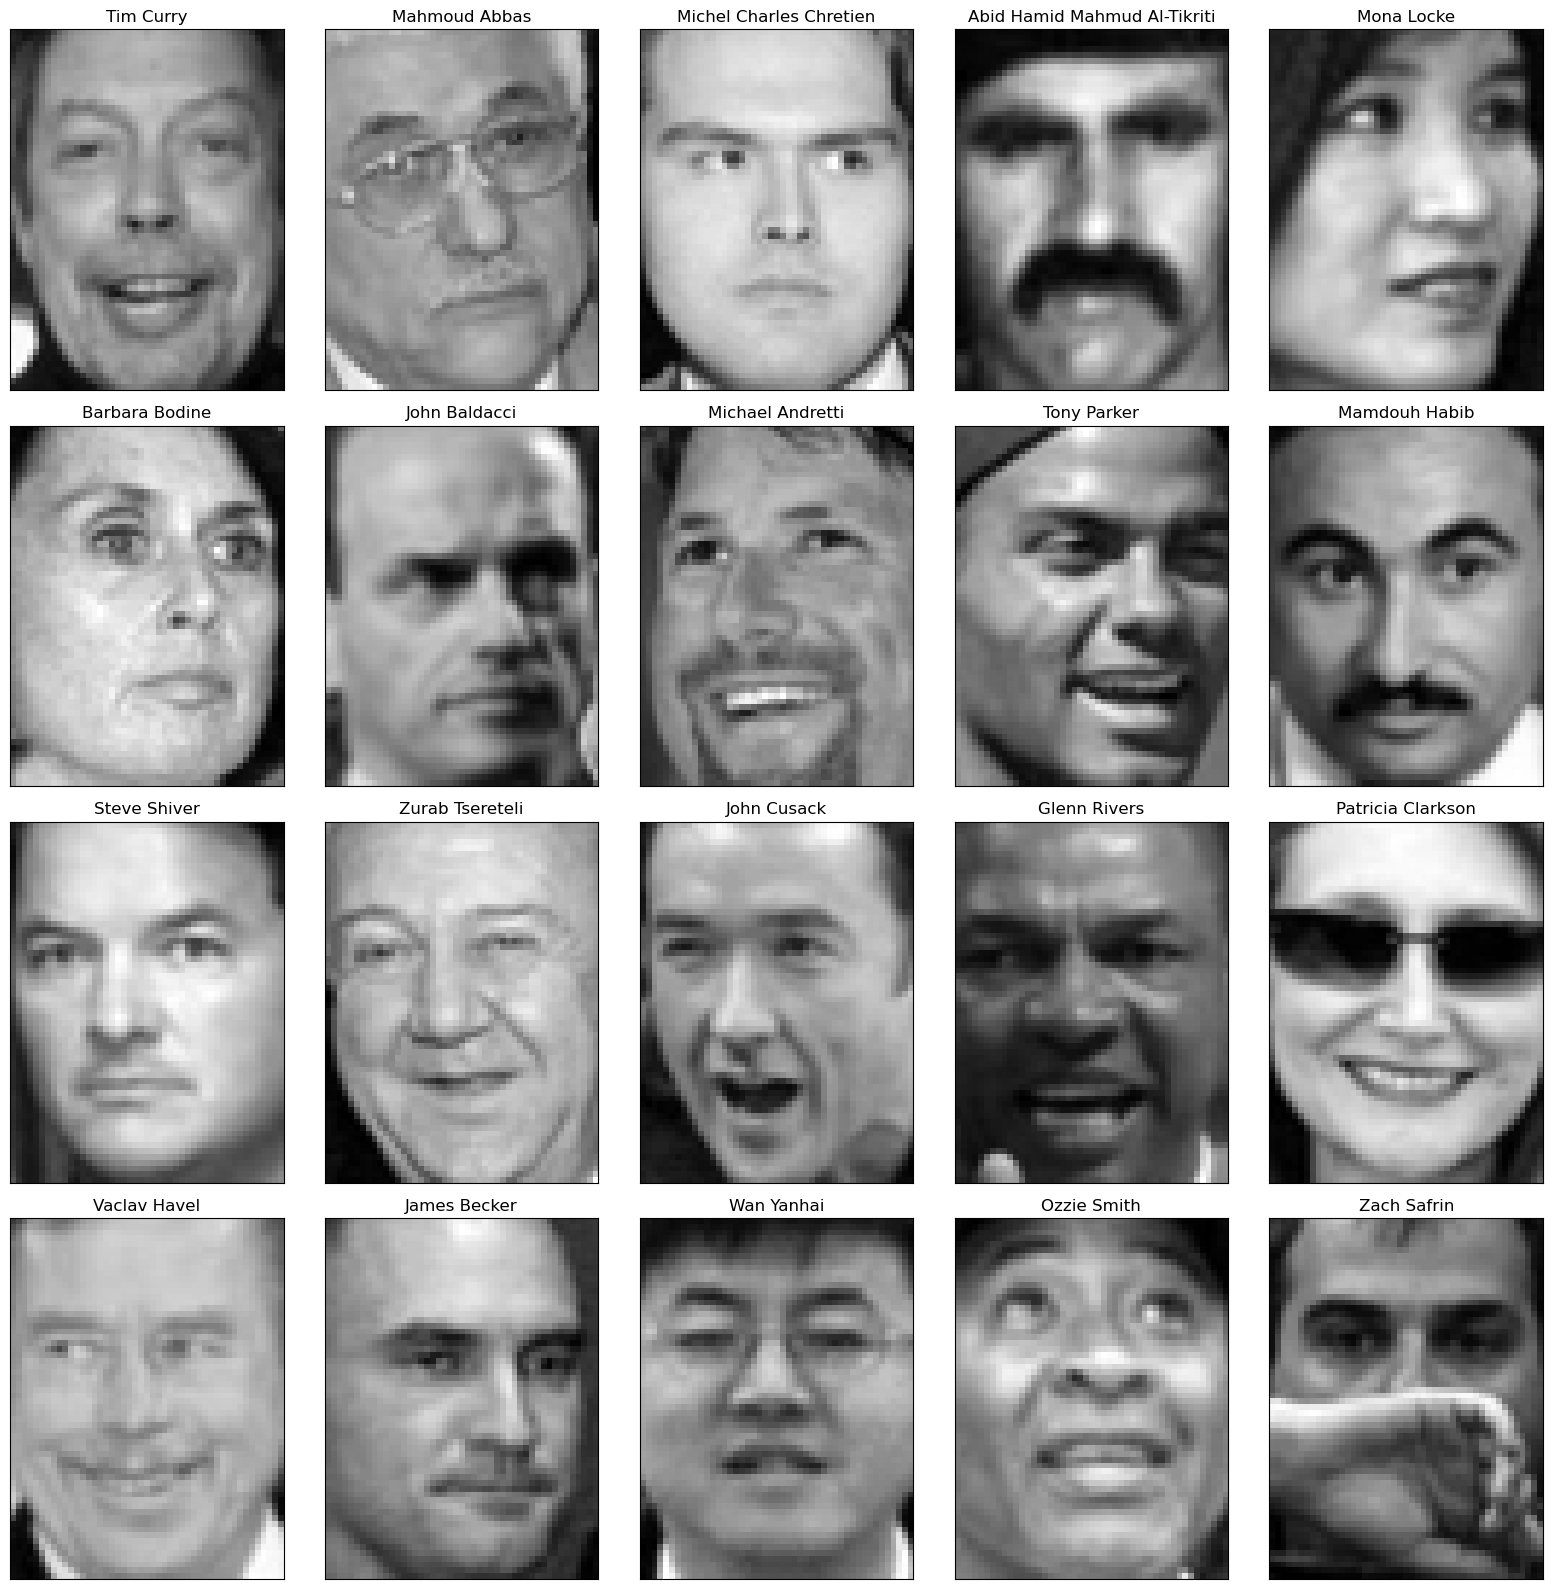

In [1]:
import warnings
from sklearn import datasets
warnings.filterwarnings('ignore', category=DeprecationWarning)

data = datasets.fetch_lfw_people()  # download the data (if they are not cached already)

%matplotlib inline
import matplotlib.pyplot as plt

def plot_img(ax, img, title=''):    # simple function to plot an image
    ax.imshow(img, cmap=plt.cm.gray)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(title)

plt.figure(figsize=(16,16))         # plot first 20 faces from the dataset
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    plot_img(ax, data.data[i].reshape((62,47)), data.target_names[data.target[i]])
    
plt.tight_layout()

Now let's apply PCA analysis to the images and see what the major components look like (i.e. the actual vectors with the largest eigenvalues). It's good to realize that the components in this case are again pictures of faces. They actually form some smaller base of the original space. We will display them as images.

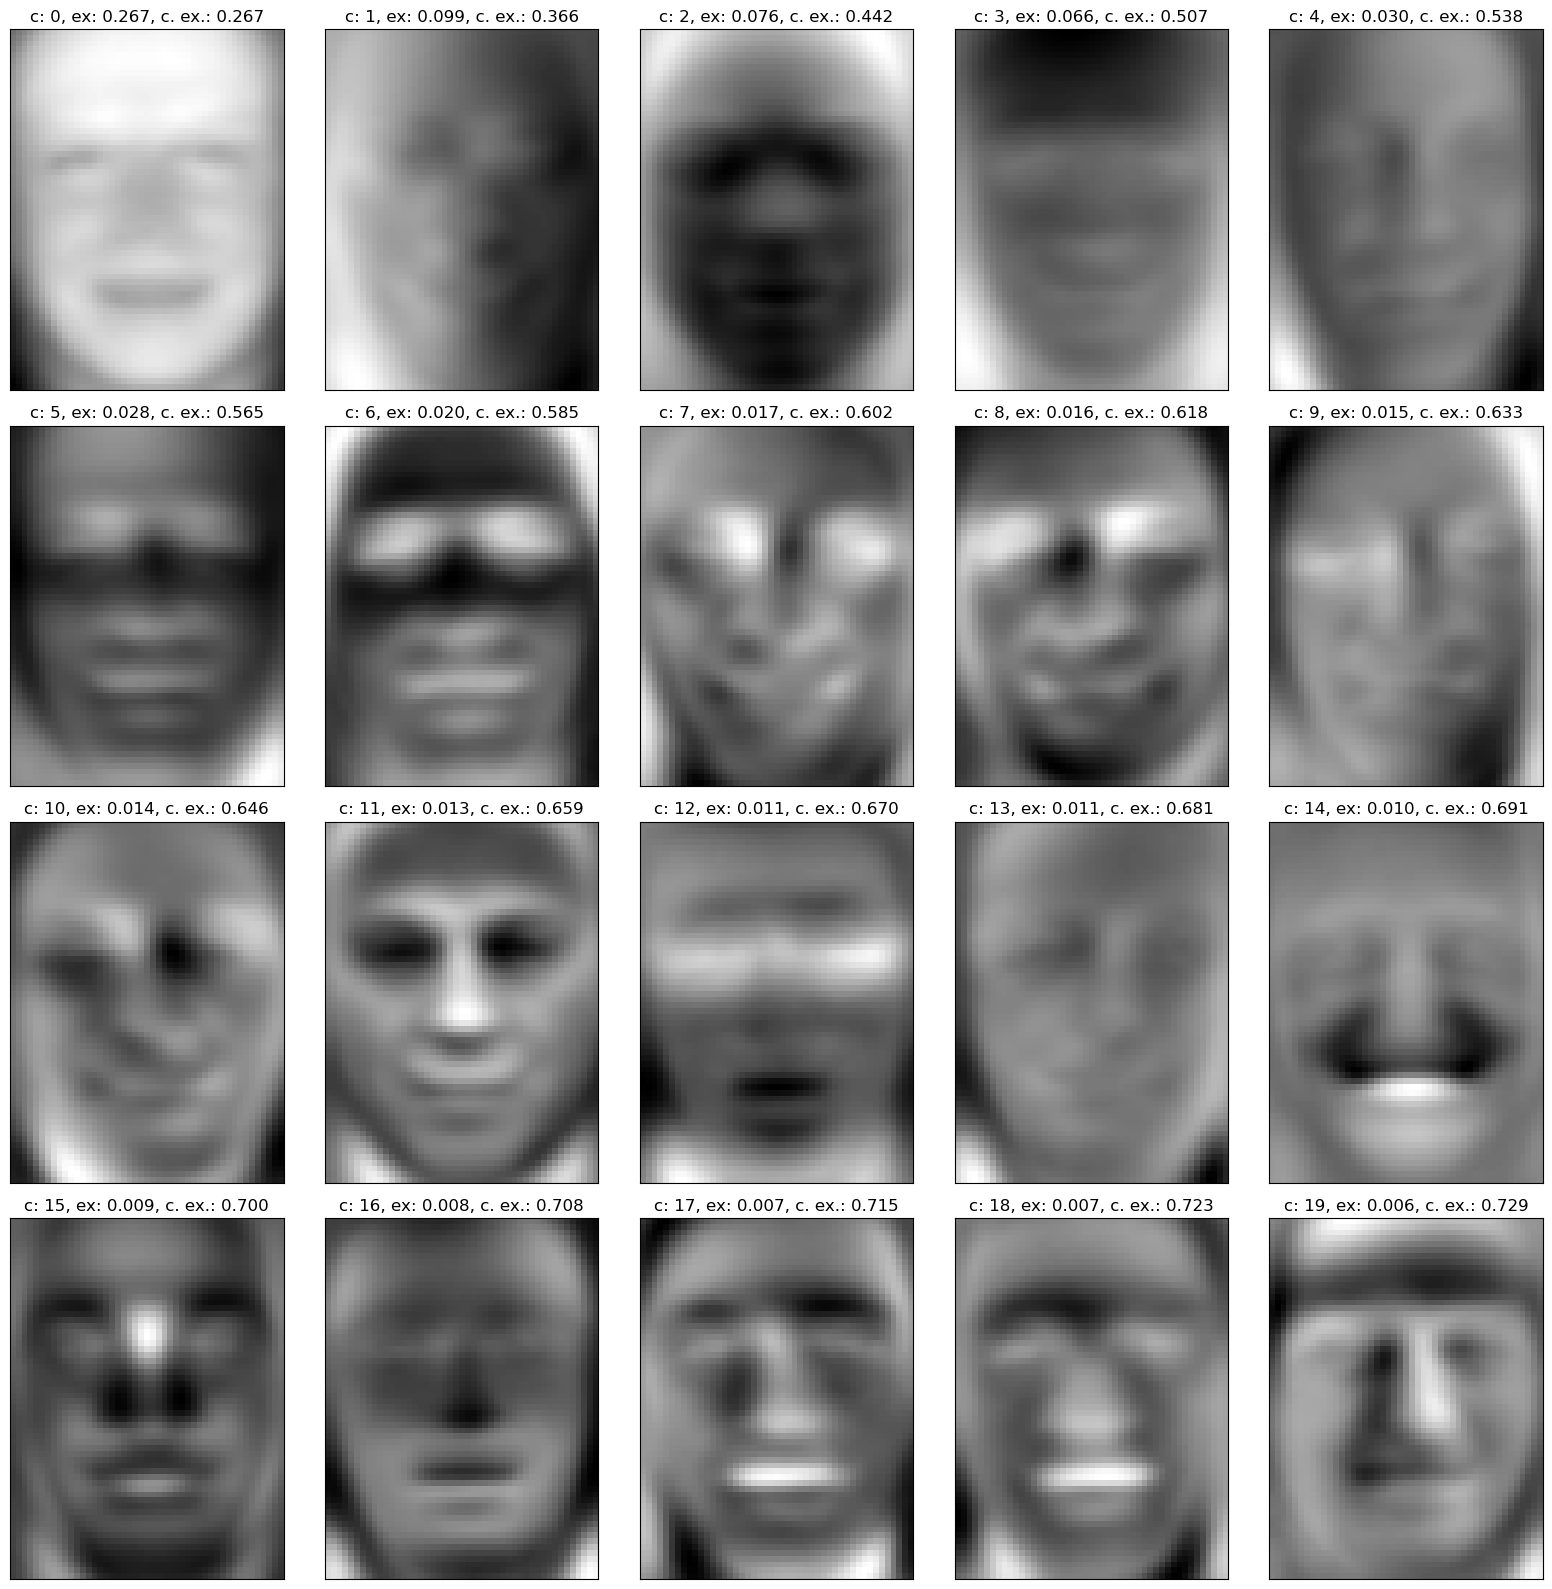

In [2]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit(data.data)       # train PCA analysis

plt.figure(figsize=(16,16)) # show 20 primary components
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'c: %d, ex: %.3f, c. ex.: %.3f' % (i, pca.explained_variance_ratio_[i], sum(pca.explained_variance_ratio_[:i+1]))
    plot_img(ax, pca.components_[i].reshape((62,47)), title)

plt.tight_layout()

When we then transform an image using PCA analysis, we're actually looking for coefficients of the linear combination of these components that resemble the input image (we're looking for the projection of that image onto the subspace given by those compotents).

So let's transform an image and look at the coefficients it gets. It's more interesting to look at how much the projected image resembles the original. We'll plot that for different numbers of the main components.

transformation:  [[ 3.2356243   5.4778147   3.4931176   1.1568553   0.5316587  -0.25155103
  -1.4211969   0.20024084 -1.5285147   1.2755516 ]]


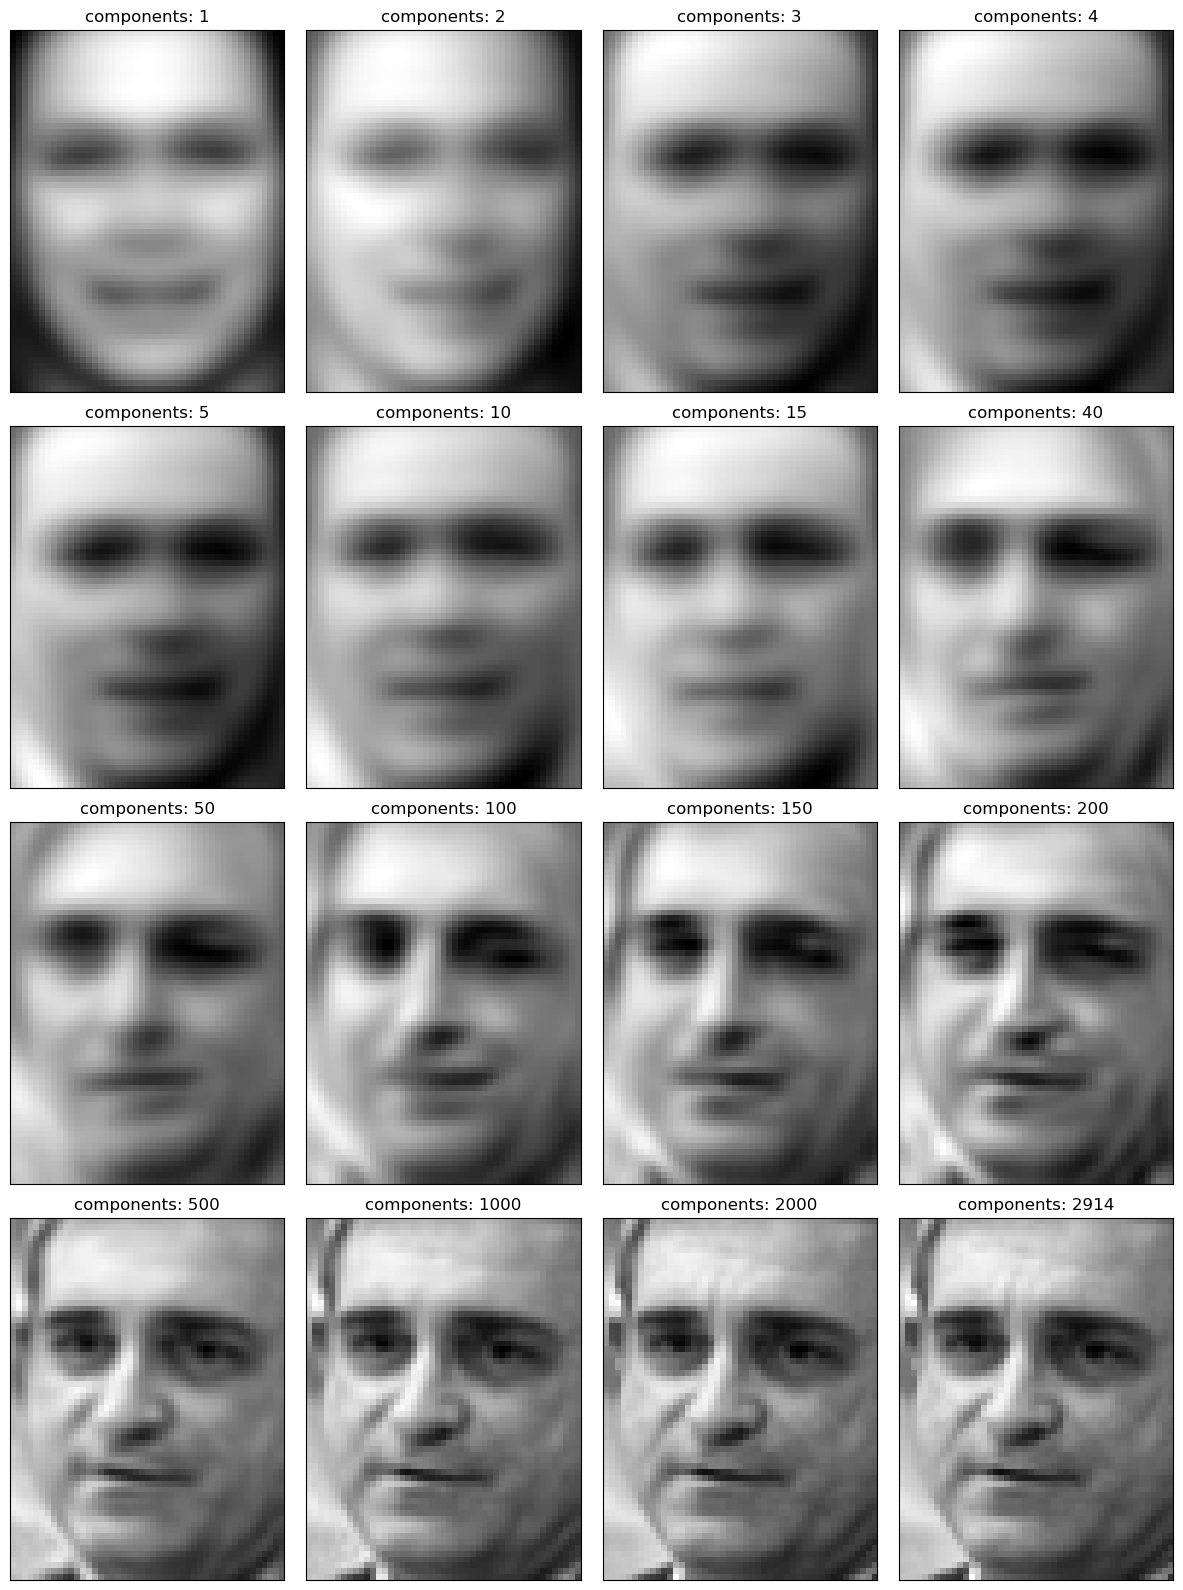

In [3]:
import numpy as np

face = pca.transform(data.data[322].reshape([1,-1]))  # choose an image and transform it with PCA

print('transformation: ', face[:, :10]) # the coefficients are not that interesting but they show us how the get the approximation of the image from the principal components

comp_counts = [1, 2, 3, 4, 5, 10, 15, 40, 50, 100, 150, 200, 500, 1000, 2000, 62*47] # plot the reconstructed image for different numbers of main components
plt.figure(figsize=(12,16))
for i, comps in zip(range(len(comp_counts)), comp_counts):    
    ax = plt.subplot(4, 4, i+1)
    img = np.dot(face[:, :comps], pca.components_[:comps, :])+pca.mean_
    plot_img(ax, img.reshape((62,47)), 'components: %d' % comps)
    
plt.tight_layout()

Let's try, for comparison the truncated SVD, that's the SVD decomposition, from which only the first vectors are taken. We'll see that the results are almost the same. As we've already mentioned, the advantage of SVD is that it can work with sparse matrices and it's a bit more efficient. PCA, on the other hand, is useful if we only want a few main components. The results of both methods are very similar.

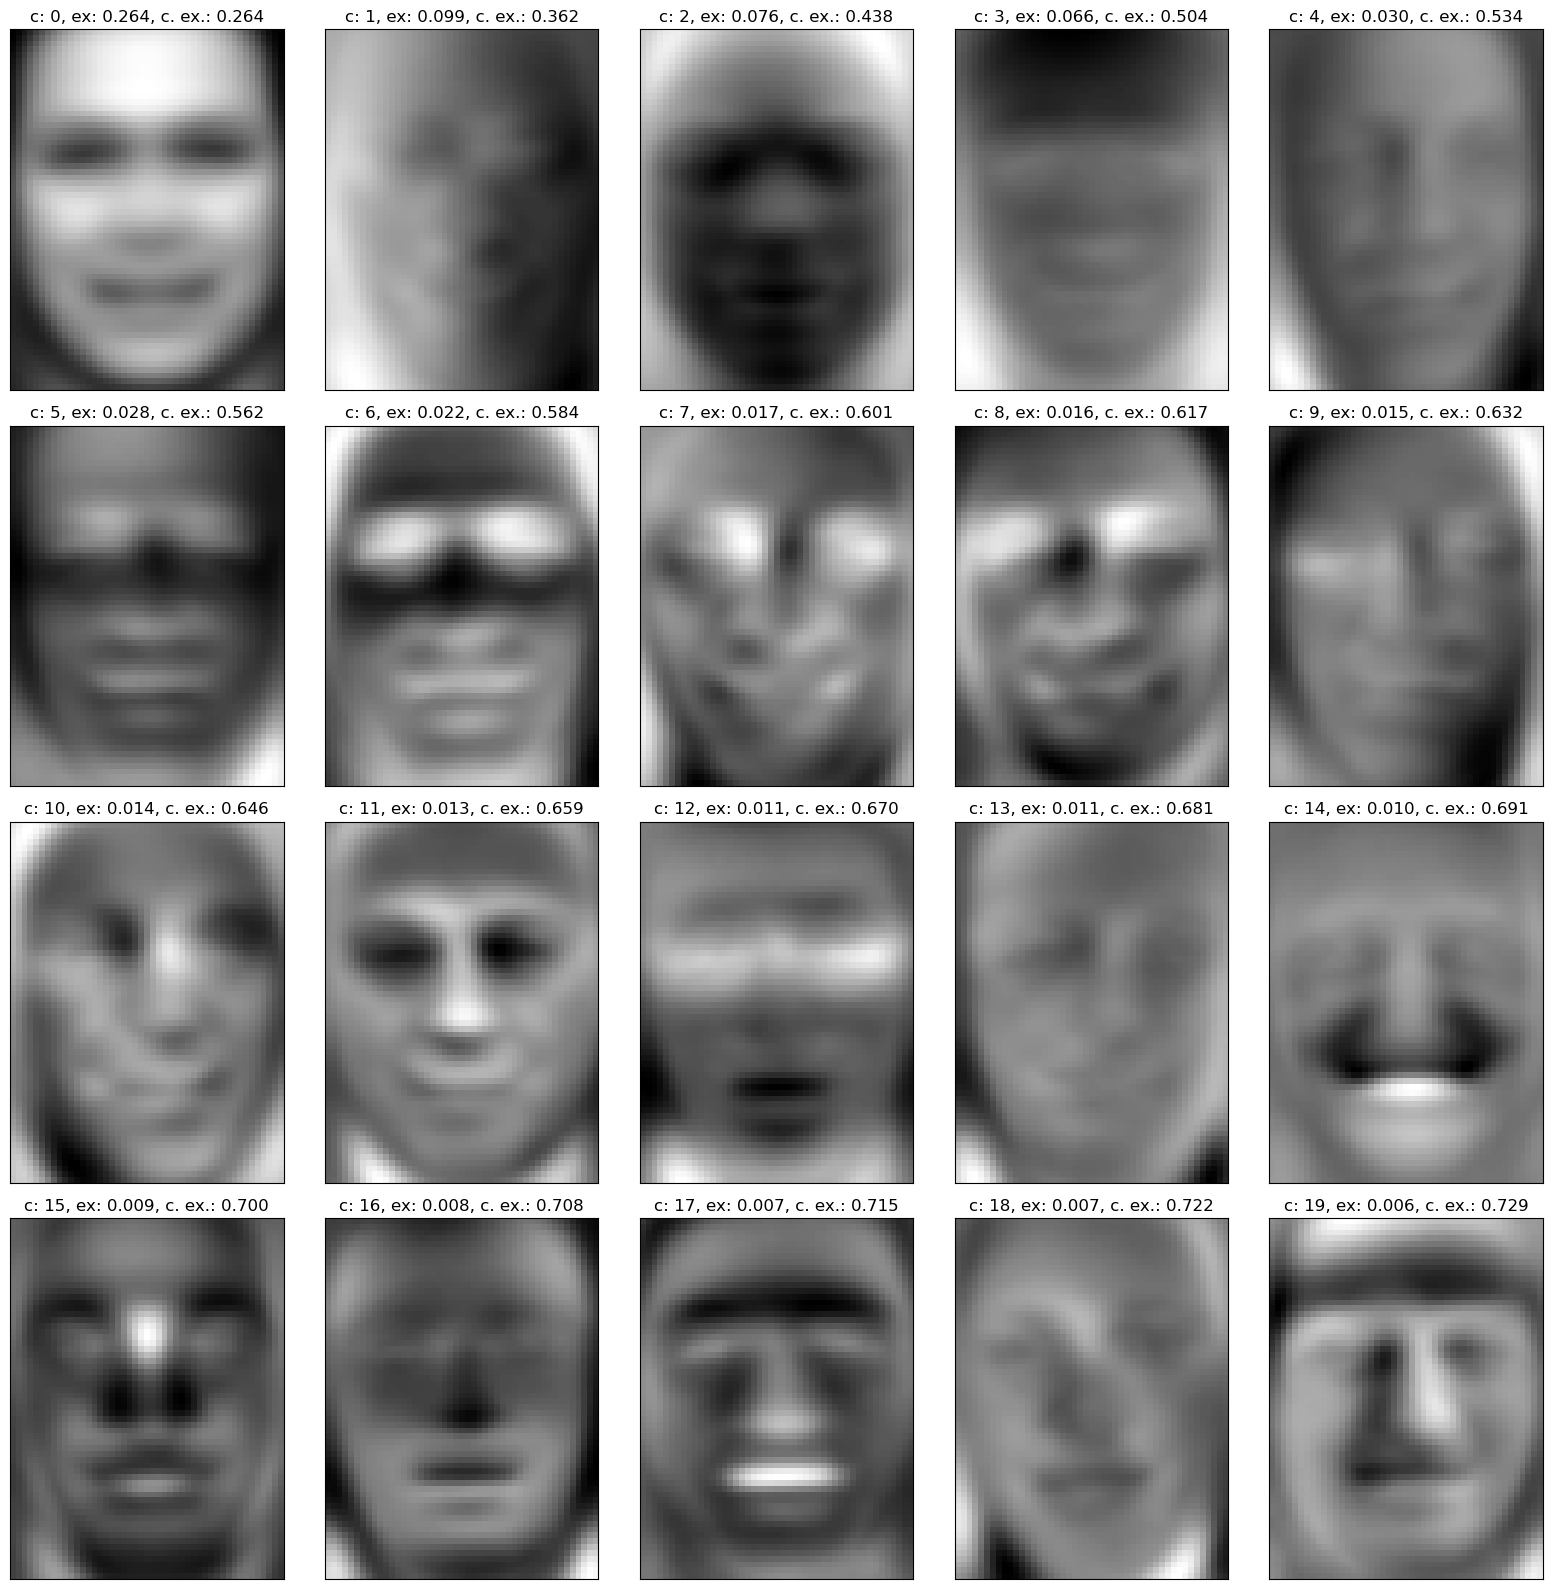

In [4]:
svd = decomposition.TruncatedSVD(n_components=20, algorithm='arpack', n_iter=20)
svd.fit(data.data)

plt.figure(figsize=(16,16))
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'c: %d, ex: %.3f, c. ex.: %.3f' % (i, svd.explained_variance_ratio_[i], sum(svd.explained_variance_ratio_[:i+1]))
    plot_img(ax, svd.components_[i].reshape((62,47)), title)

plt.tight_layout()

## NMF - Non-negative Matrix Factorization

Another method that can be used to reduce the dimensionality of data is Non-negative Matrix Factorization (NMF). The goal of NMF is to approximate the matrix $V$ as the product of two matrices $W$ and $H$, with a possible error term of $U$, i.e. $V$ = $WH + U$. The matrices $V$, $W$ and $H$ contain only non-negative numbers. The motivation, of course, is to find the matrices $W$ and $H$ that are much smaller than the original matrix $V$.

We can use this if our data is non-negative. We put the data in the matrix $V$ (rows are instances, columns are attributes) and try to find NMF by minimizing the decomposition error expressed in the matrix $U$ (the error is often calculated as the Frobenius norm, i.e. the square root of the sum of the squares of all the numbers in the matrix).

The matrix $W$ then contains the main decomposition components, which are assembled using linear combinations (contained in the matrix $H$) to approximate the original inputs.

Let's try NMF again on our pictures. We will train it and display the components.

C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


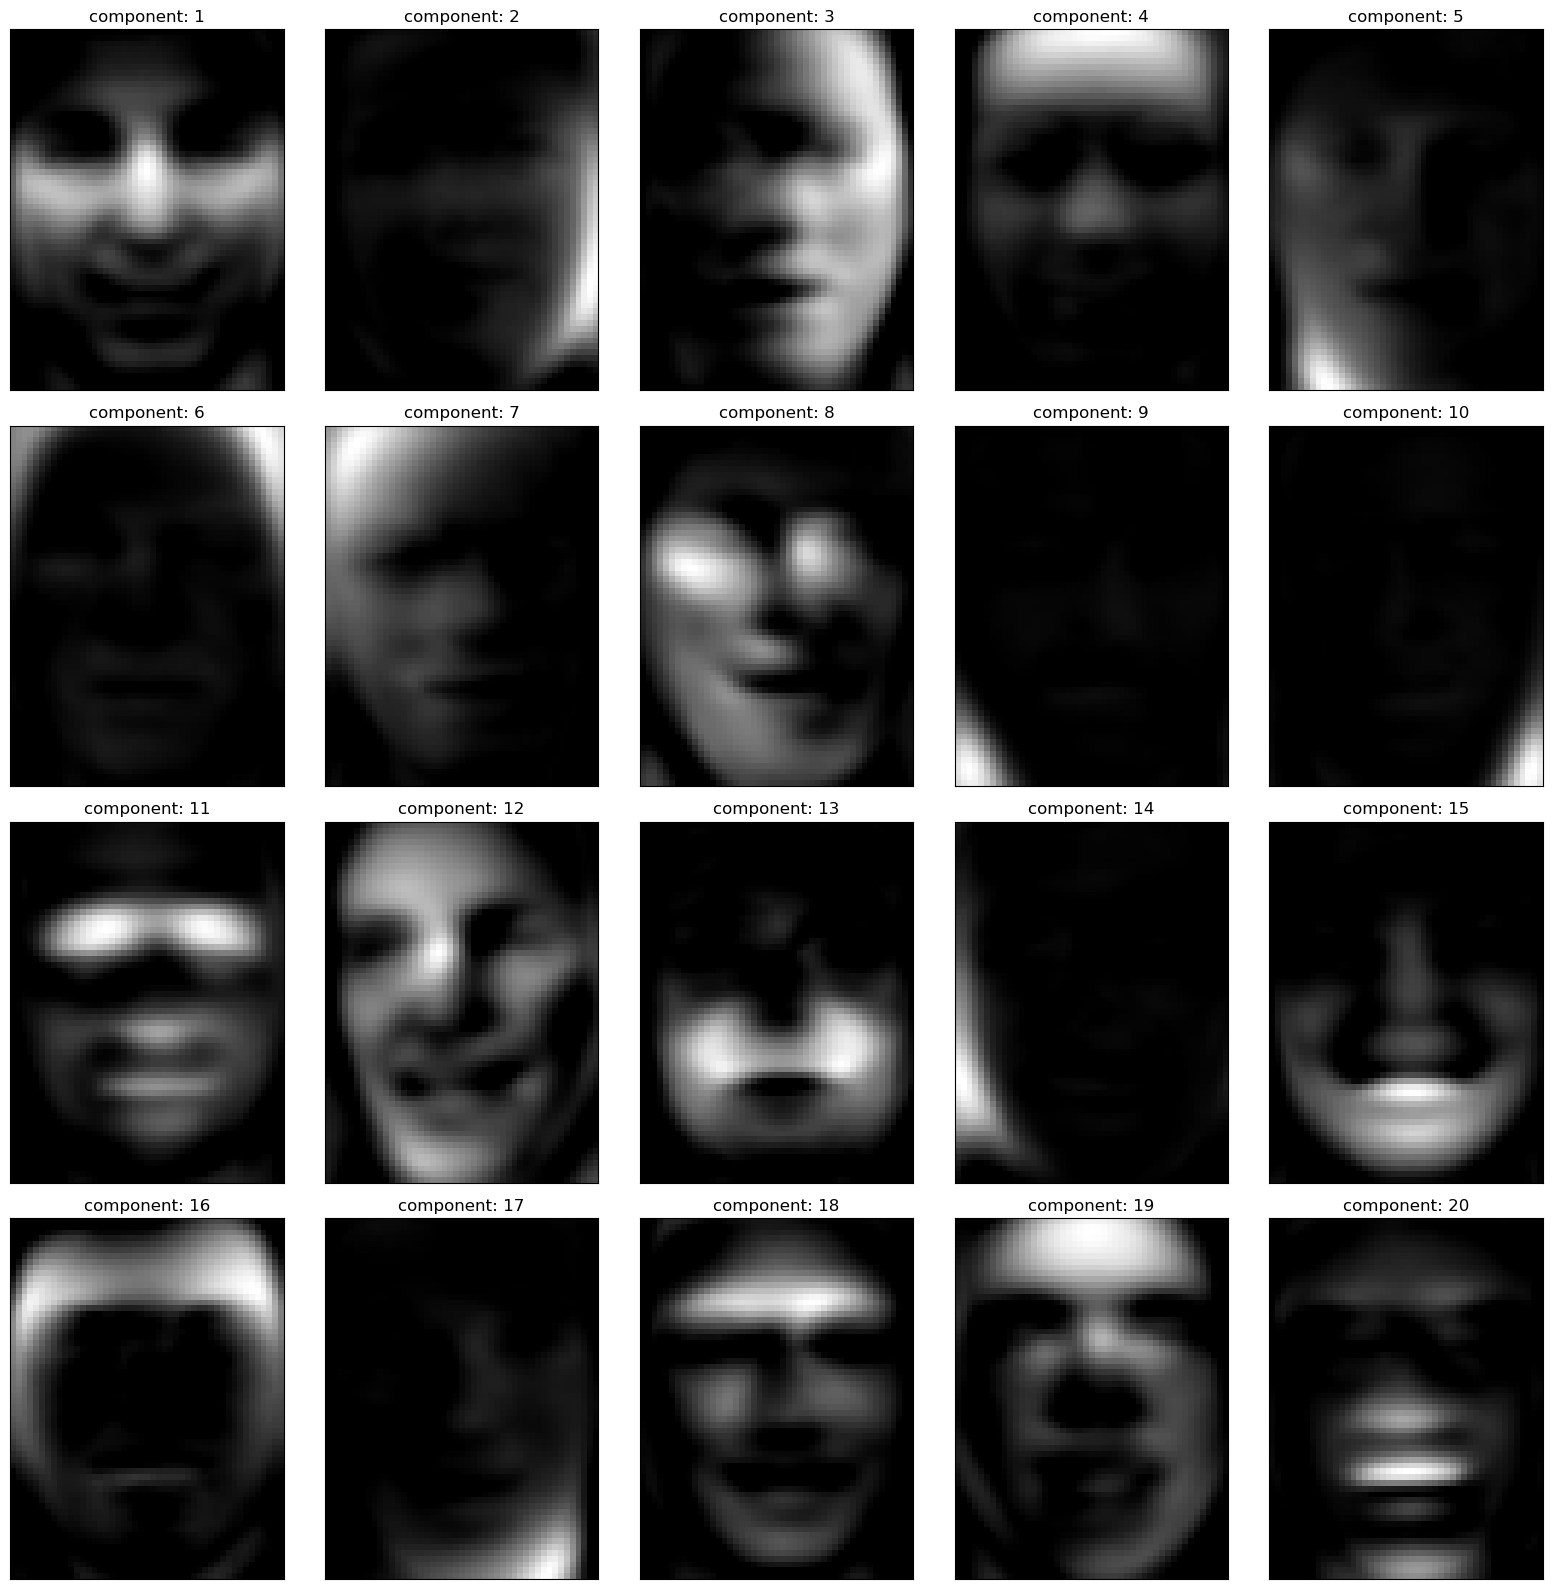

In [5]:
nmf = decomposition.NMF(n_components=20)
nmf.fit(data.data)

plt.figure(figsize=(16,16)) # plot 20 main components
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'component: %d' % (i+1)
    plot_img(ax, nmf.components_[i].reshape((62,47)), title)
    
plt.tight_layout()

We can see what the approximation of our image looks like depending on the number of components in the NMF. The calculation is slow for higher numbers of components, so we'll only do the first 40.

C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve conve

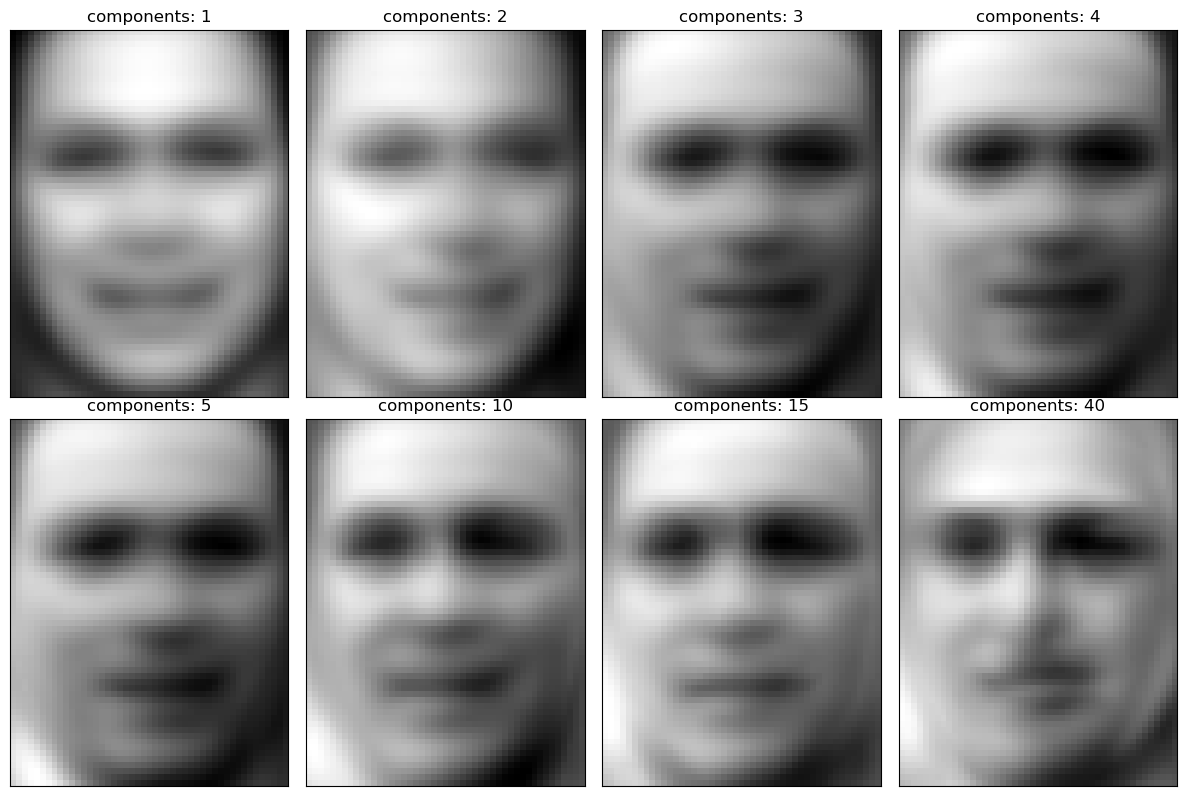

In [6]:
comp_counts = [1, 2, 3, 4, 5, 10, 15, 40] # plot the reconstructed image for different numbers of components
plt.figure(figsize=(12,8))
for i, comps in zip(range(len(comp_counts)), comp_counts):
    nmf = decomposition.NMF(n_components=comps)
    nmf.fit(data.data)
    face = nmf.transform(data.data[322].reshape([1, -1]))  # choose an image and transform it with NMF
    ax = plt.subplot(2, 4, i+1)
    img = np.dot(face, nmf.components_)
    plot_img(ax, img.reshape((62,47)), 'components: %d' % comps)

plt.tight_layout()

## ICA - Independent Component Analysis

Independent Component Analysis (ICA), unlike the previous two methods, looks for components that are independent of each other. ICA was originally used in the field of signal processing, but it can also be used in general. It has very good results in signal processing and can extract its main components from a linear combination of signals. Imagine that the signal is the sum of several sine waves, ICA can often find the original sine waves that make up the signal. We will try this method again and apply it to our dataset and look at the results.

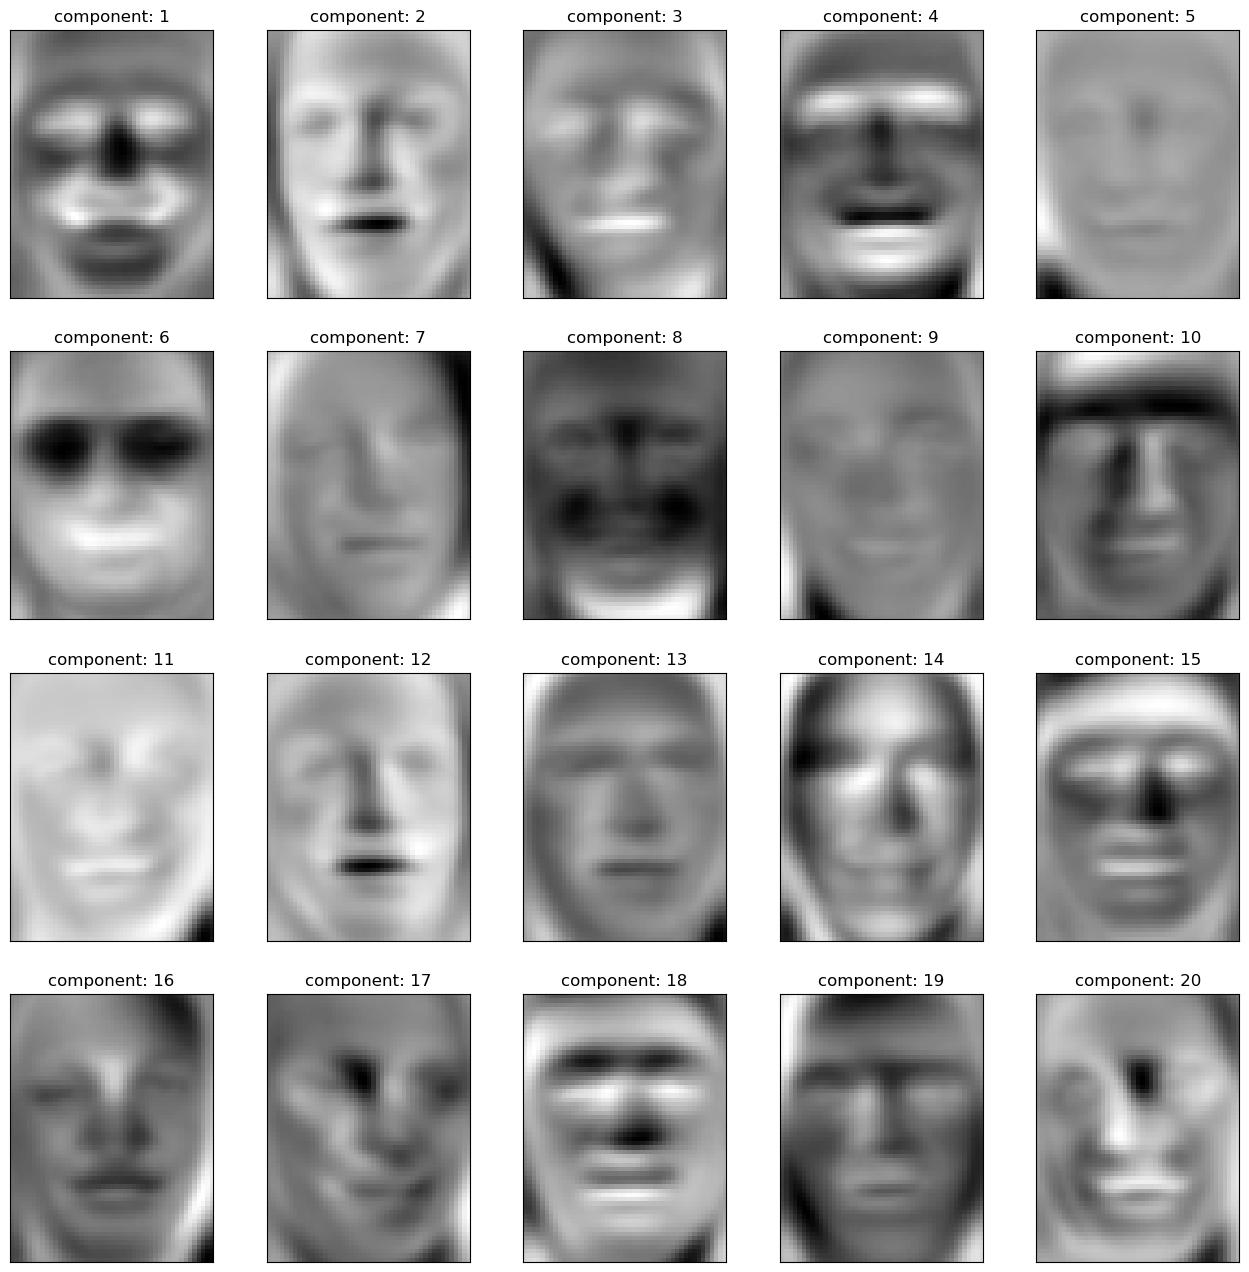

In [7]:
ica = decomposition.FastICA(n_components=20)
ica.fit(data.data)

plt.figure(figsize=(16,16)) # plot the 20 main components
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'component: %d' % (i+1)
    plot_img(ax, ica.components_[i].reshape((62,47)), title)

## k-Means

The $k$-Means algorithm is quite well known as a clustering algorithm, but it can also be used to reduce data. This can be done by expressing individual instances as distances from the centers of individual clusters. The selected number of clusters then affects the dimensionality of the reduced space. Let's try again with $k=20$ on our data.

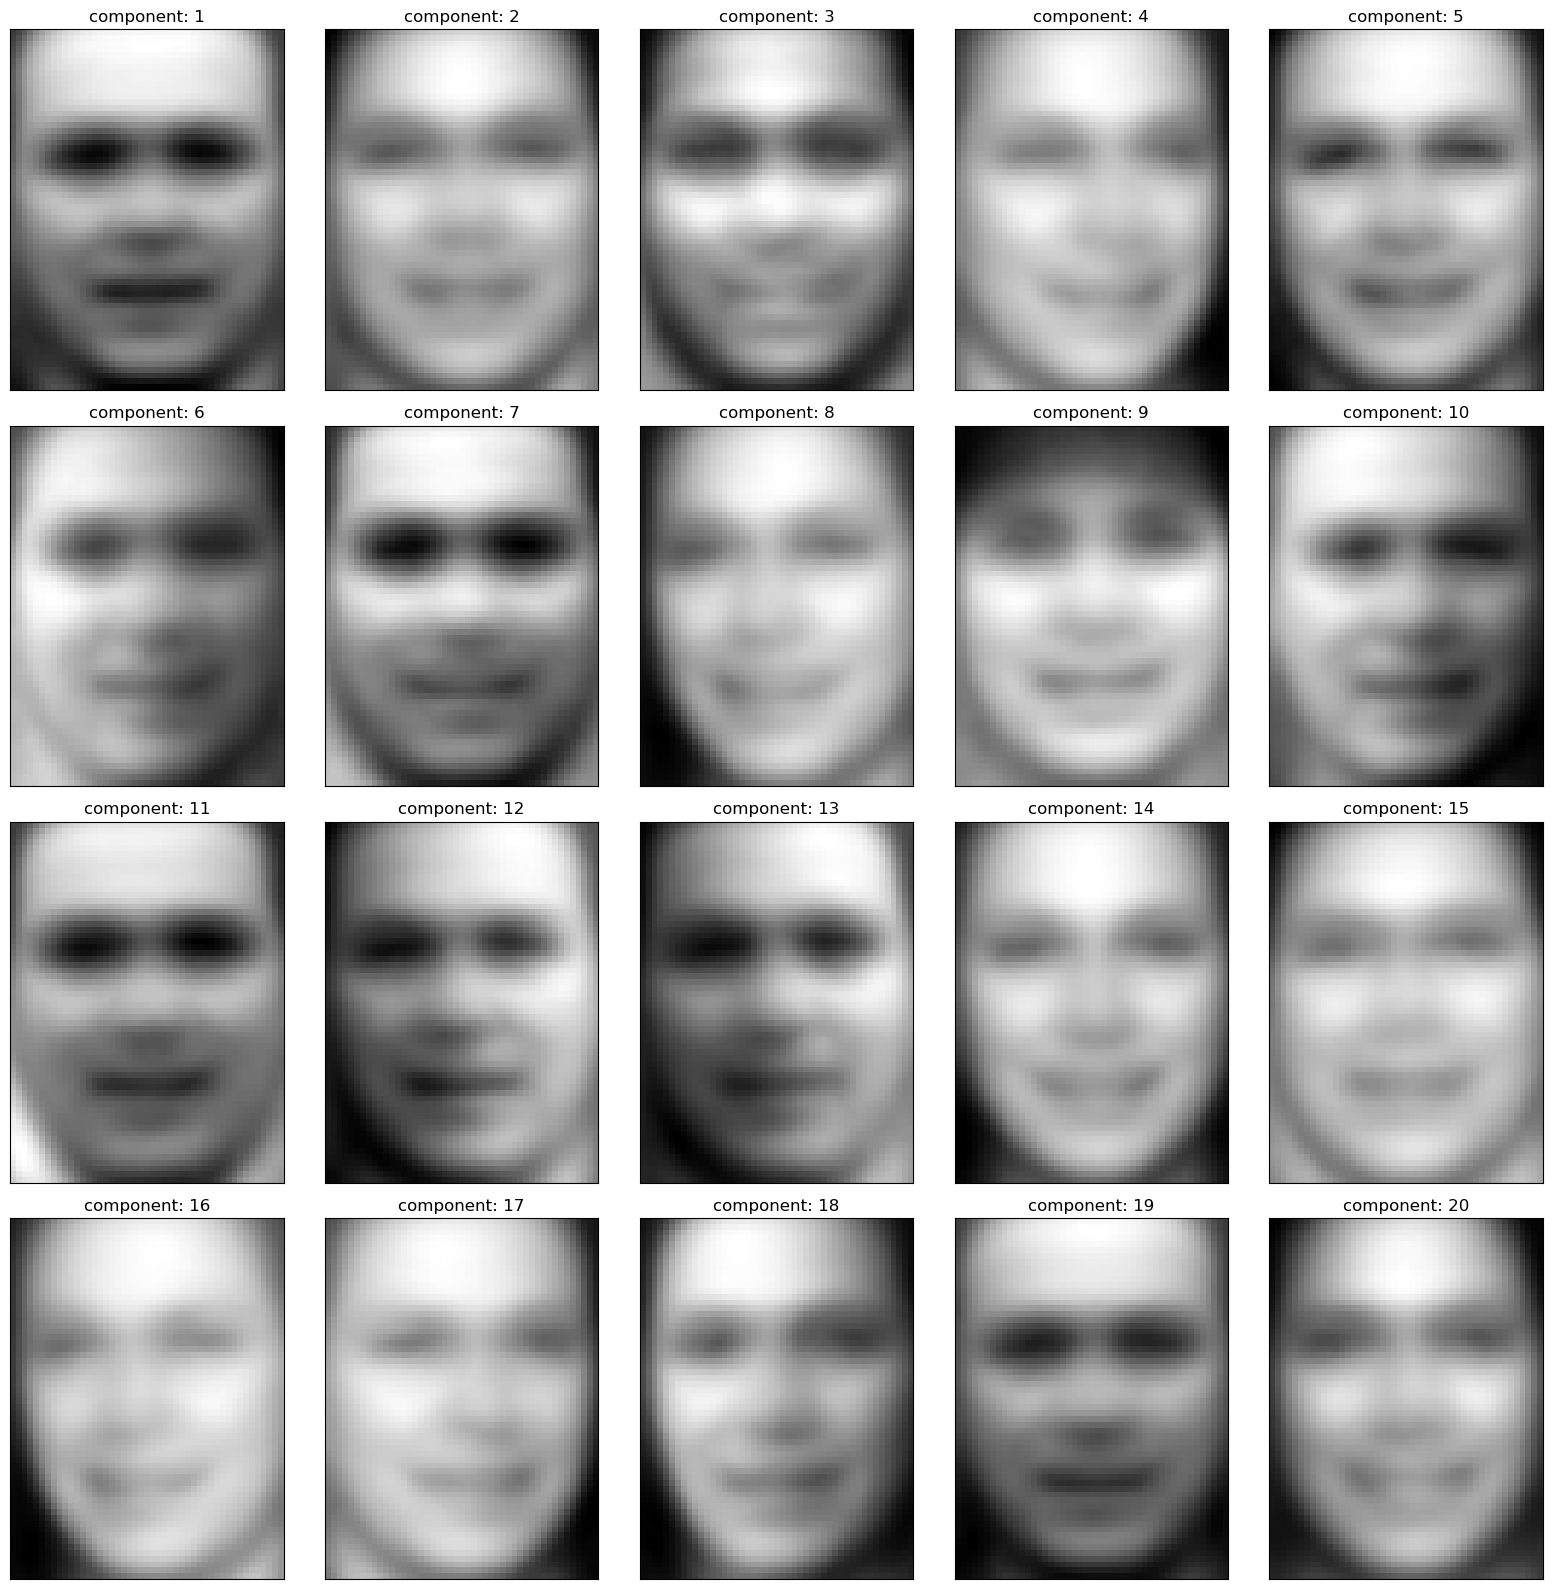

In [8]:
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=20)
kmeans.fit(data.data)

plt.figure(figsize=(16,16)) # plot the 20 main components
for i in range(20):
    ax = plt.subplot(4, 5 ,i+1)
    title = 'component: %d' % (i+1)
    plot_img(ax, kmeans.cluster_centers_[i].reshape((62,47)), title)
    
plt.tight_layout()

## t-SNE (t-distributed stochastic neighbor embedding)

In the first lesson we mentioned the t-SNE method. It is only suitable for data visualization and cannot be used directly to reduce the dimension in case we want to display previously unknown data with it. If the test set is already known in advance, it can be used. The main reason for this disadvantage is that t-SNE optimizes directly the distribution of points in a space with a lower dimension, so it does not look for a transformation that could be used in general.

The t-SNE method first defines the distance between points in a multidimensional space and then tries to find the distribution of points in a space with a lower dimension that minimizes the so-called Kullback-Leibler divergence, that is the measure of similarity between two probability distributions. Specifically, the distance $p_{ij}$ of two instances of $x_i$ and $x_j$ in a multidimensional space is computed as

$$p_{j|i} = \frac{\exp(-\lVert\mathbf{x}_i - \mathbf{x}_j\rVert^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\lVert\mathbf{x}_i - \mathbf{x}_k\rVert^2 / 2\sigma_i^2)},$$
$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}.$$

Subsequently, t-SNE searches for the distribution of points $y_i = f(x_i)$, whose similarity $q_{ij}$ is computed similarly to above (but instead of Gaussians, the Student's t-distribution is used) $$q_{ij} = \frac{(1 + \lVert \mathbf{y}_i - \mathbf{y}_j\rVert^2)^{-1}}{\sum_{k \neq l} (1 + \lVert \mathbf{y}_k - \mathbf{y}_l\rVert^2)^{-1}}.$$ In order to find a suitable distribution of points, the Kullback-Leibler distribution of these two distributions is optimized $$KL(P||Q) = \sum_{i \neq j} p_{ij} \\, \log \frac{p_{ij}}{q_{ij}}.$$

We'll show t-SNE later when we try to display data in two dimensions.

## Comparing individual methods

Let's have a look again at the five most important components found by the above methods. To compare how the methods project data into a 2D space, we take smaller data, specifically from our dataset we select only the faces of people who are in it at least 80 times. We get 1,140 images of five different people.

In [9]:
small_data = datasets.fetch_lfw_people(min_faces_per_person=70)
print('Number of instances: %d' % small_data.data.shape[0])
print('Number of classes: %d' % len(small_data.target_names))
print('Names: %s' % list(small_data.target_names))

Number of instances: 1288
Number of classes: 7
Names: [np.str_('Ariel Sharon'), np.str_('Colin Powell'), np.str_('Donald Rumsfeld'), np.str_('George W Bush'), np.str_('Gerhard Schroeder'), np.str_('Hugo Chavez'), np.str_('Tony Blair')]


Let's now view the five most important components found by individual methods on our smaller data.

In [10]:
clfs = [decomposition.PCA(n_components=5), 
        decomposition.TruncatedSVD(n_components=5, algorithm='randomized'),
        decomposition.TruncatedSVD(n_components=5, algorithm='arpack'),
        decomposition.NMF(n_components=5), 
        decomposition.FastICA(n_components=5), 
        cluster.KMeans(n_clusters=5)]

names = ['PCA', 'tSVD-rand', 'tSVD-arpack', 'NMF', 'ICA', 'k-means']

clfs = [clf.fit(small_data.data) for clf in clfs] # train all methods

C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


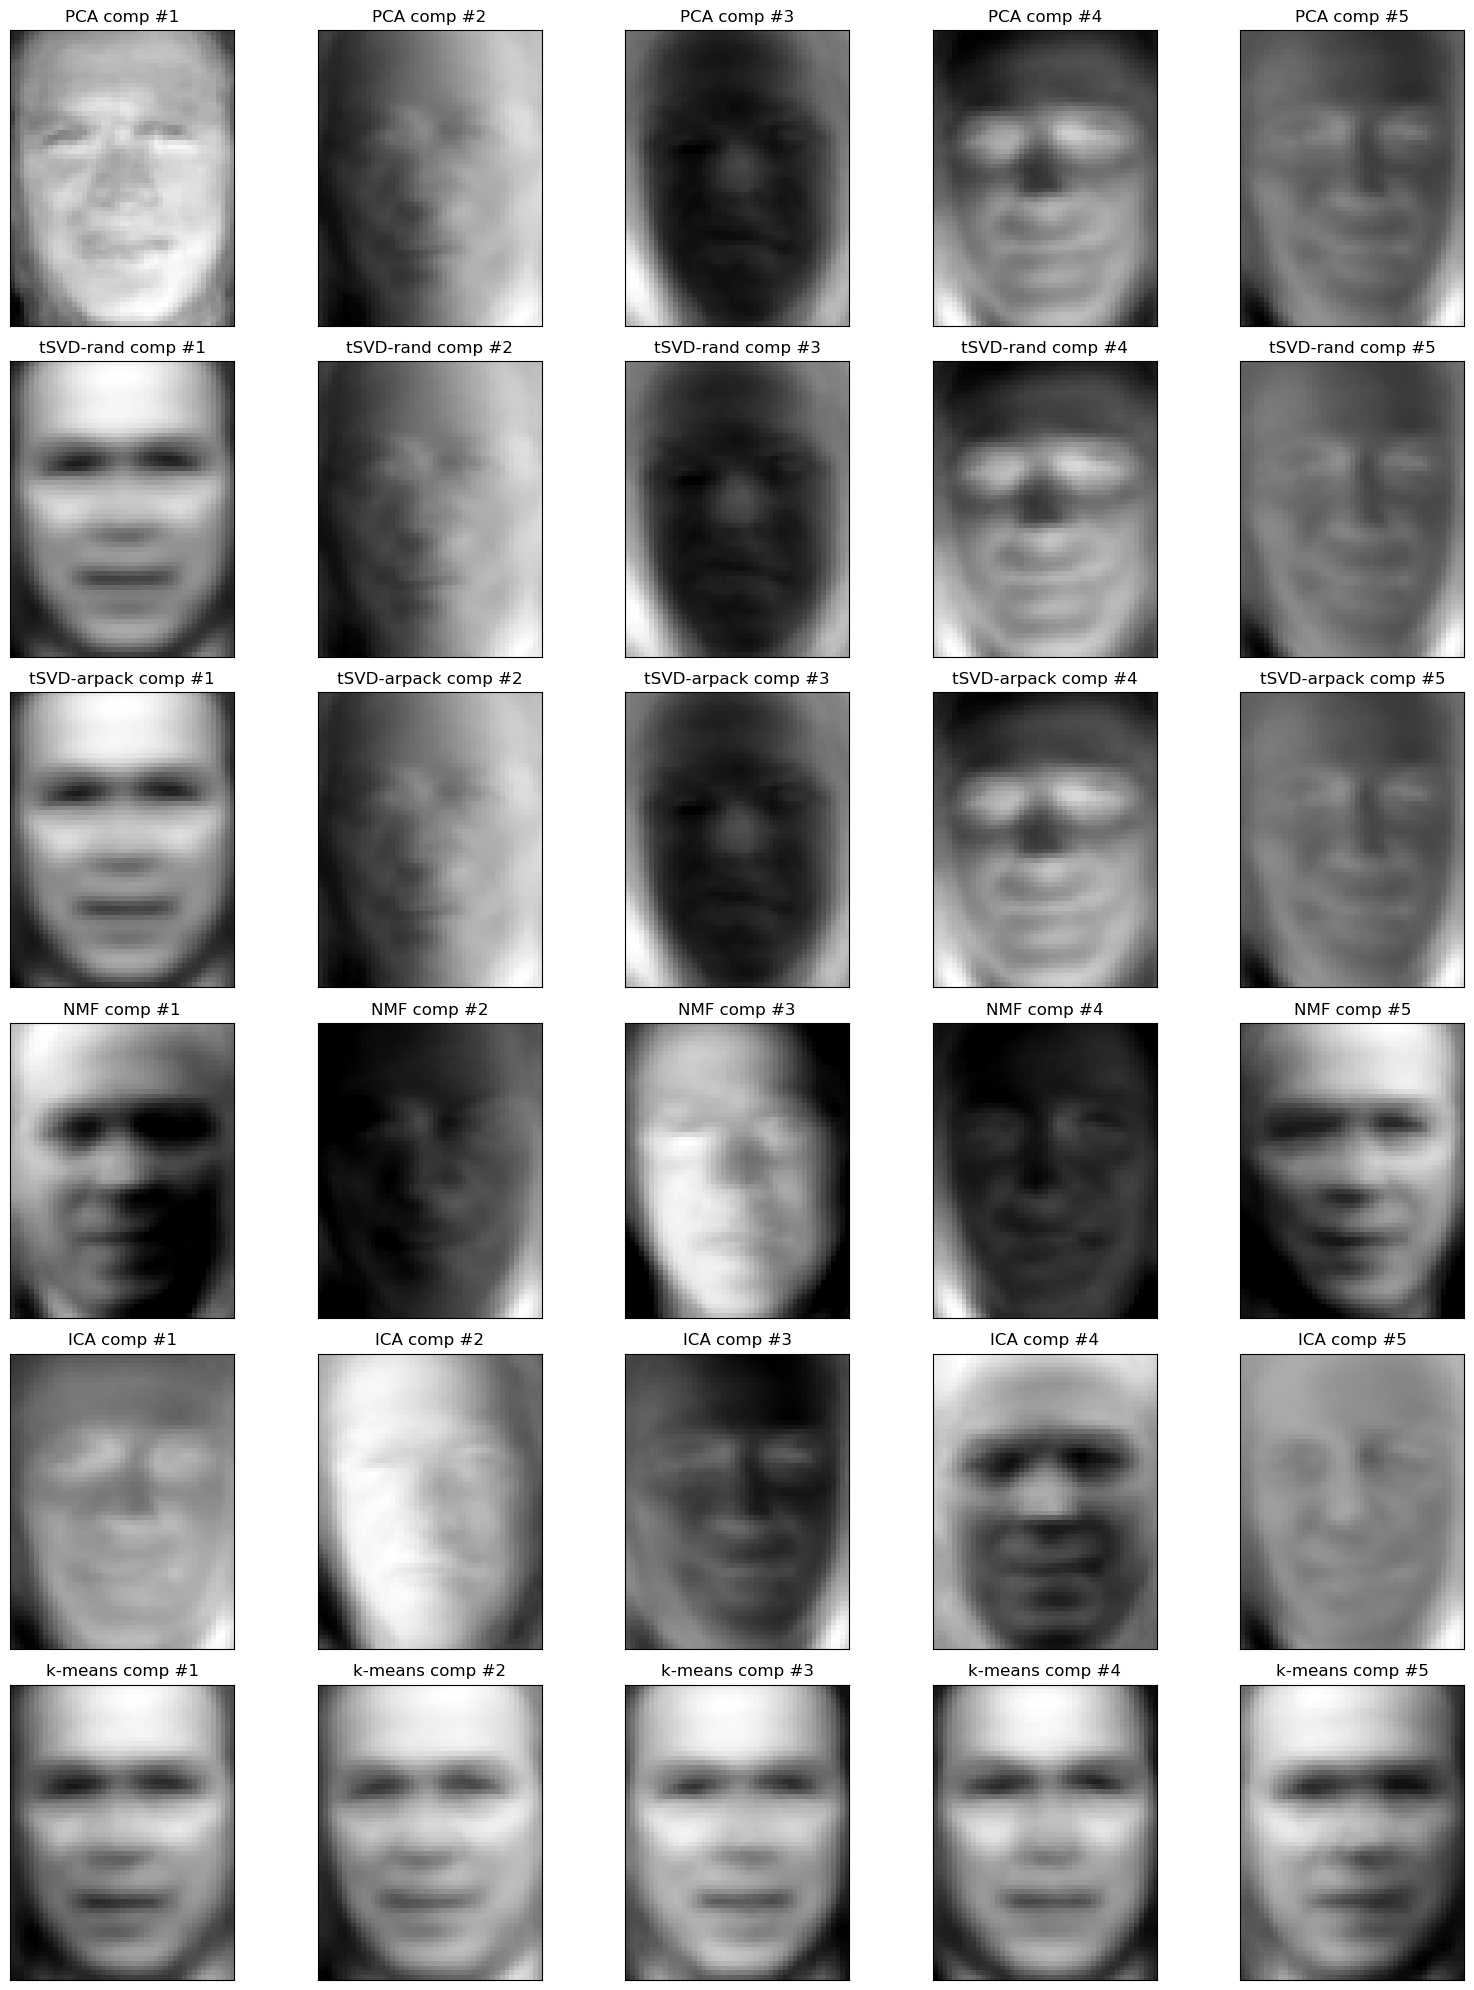

In [11]:
plt.figure(figsize=(16,20)) # show 5 main components for all methods except k-means
for j in range(5):
    for i in range(5):
        ax = plt.subplot(6, 5 , 5*j+i+1)
        title = '%s comp #%d' % (names[j], i+1)
        plot_img(ax, clfs[j].components_[i].reshape((62,47)), title)

for i in range(5):
    ax = plt.subplot(6, 5 , 25+i+1)
    title = '%s comp #%d' % (names[5], i+1)
    plot_img(ax, clfs[5].cluster_centers_[i].reshape((62,47)), title)

plt.tight_layout()

And finally, let's try to project the images into 2D and 3D space to see if they form some nice clusters. Let's try all the methods again and add t-SNE. It should be noted that when viewed in 2D (and 3D) by any method, we lose more than 99% of the data contained in the images, so we can't expect great results.

C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


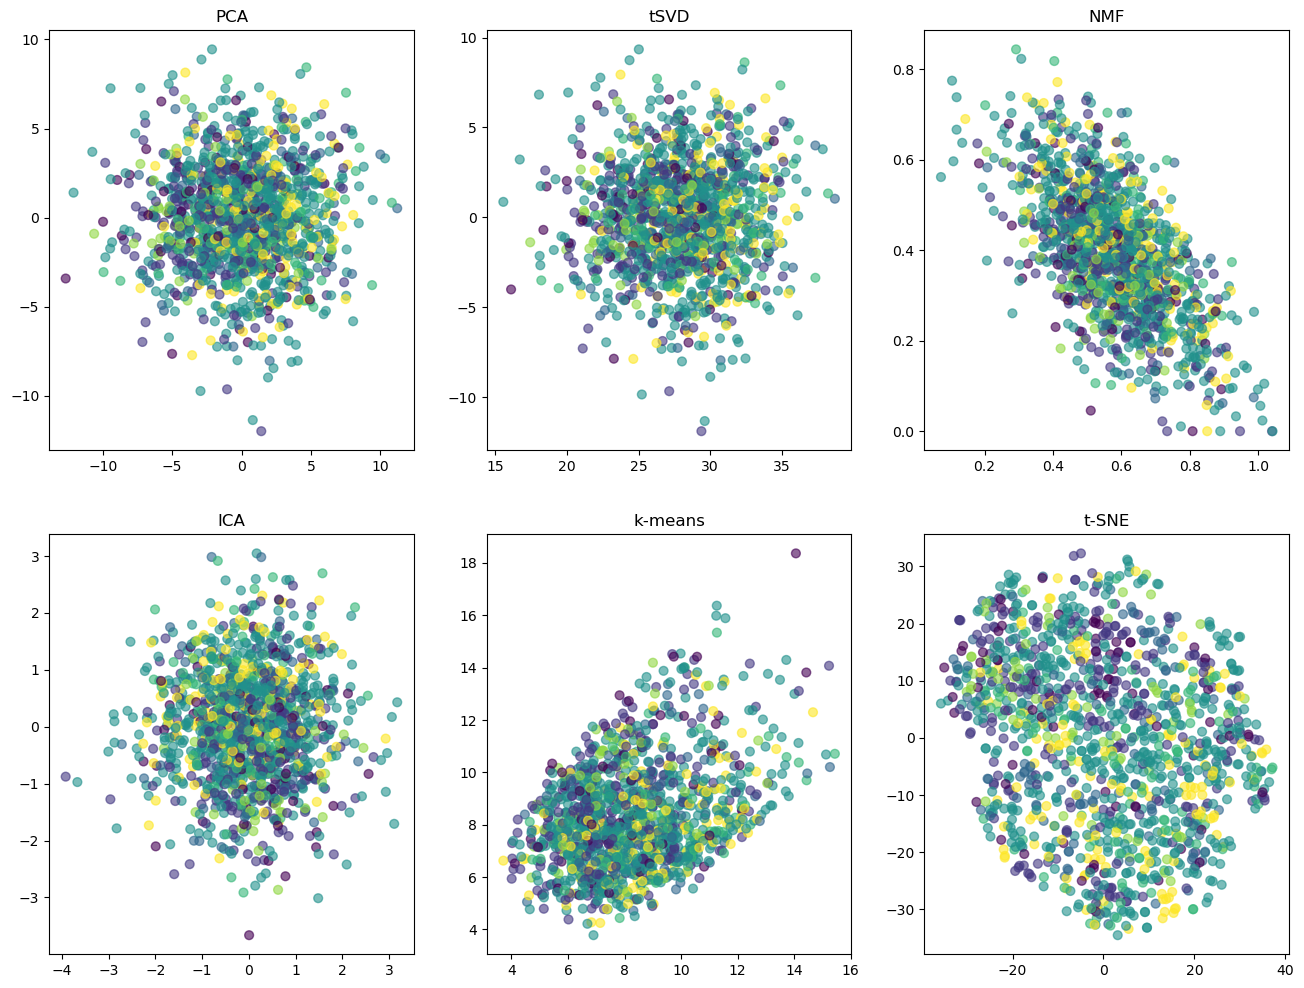

In [12]:
from sklearn import manifold

clfs = [decomposition.PCA(n_components=2), 
        decomposition.TruncatedSVD(n_components=2, algorithm='arpack'),
        decomposition.NMF(n_components=2), 
        decomposition.FastICA(n_components=2), 
        cluster.KMeans(n_clusters=2),
        manifold.TSNE(n_components=2)]

names = ['PCA', 'tSVD', 'NMF', 'ICA', 'k-means', 't-SNE']

trans = [clf.fit_transform(small_data.data) for clf in clfs]

from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
colors = lbl.fit_transform(small_data.target)

plt.figure(figsize=(16, 12))
for tr, name, i in zip(trans, names, range(6)):
    plt.subplot(2, 3, i+1)
    plt.scatter(tr[:, 0], tr[:, 1], c=colors, s=40, alpha=0.6)
    plt.title(name)

C:\Users\Martin\anaconda3\envs\acim\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


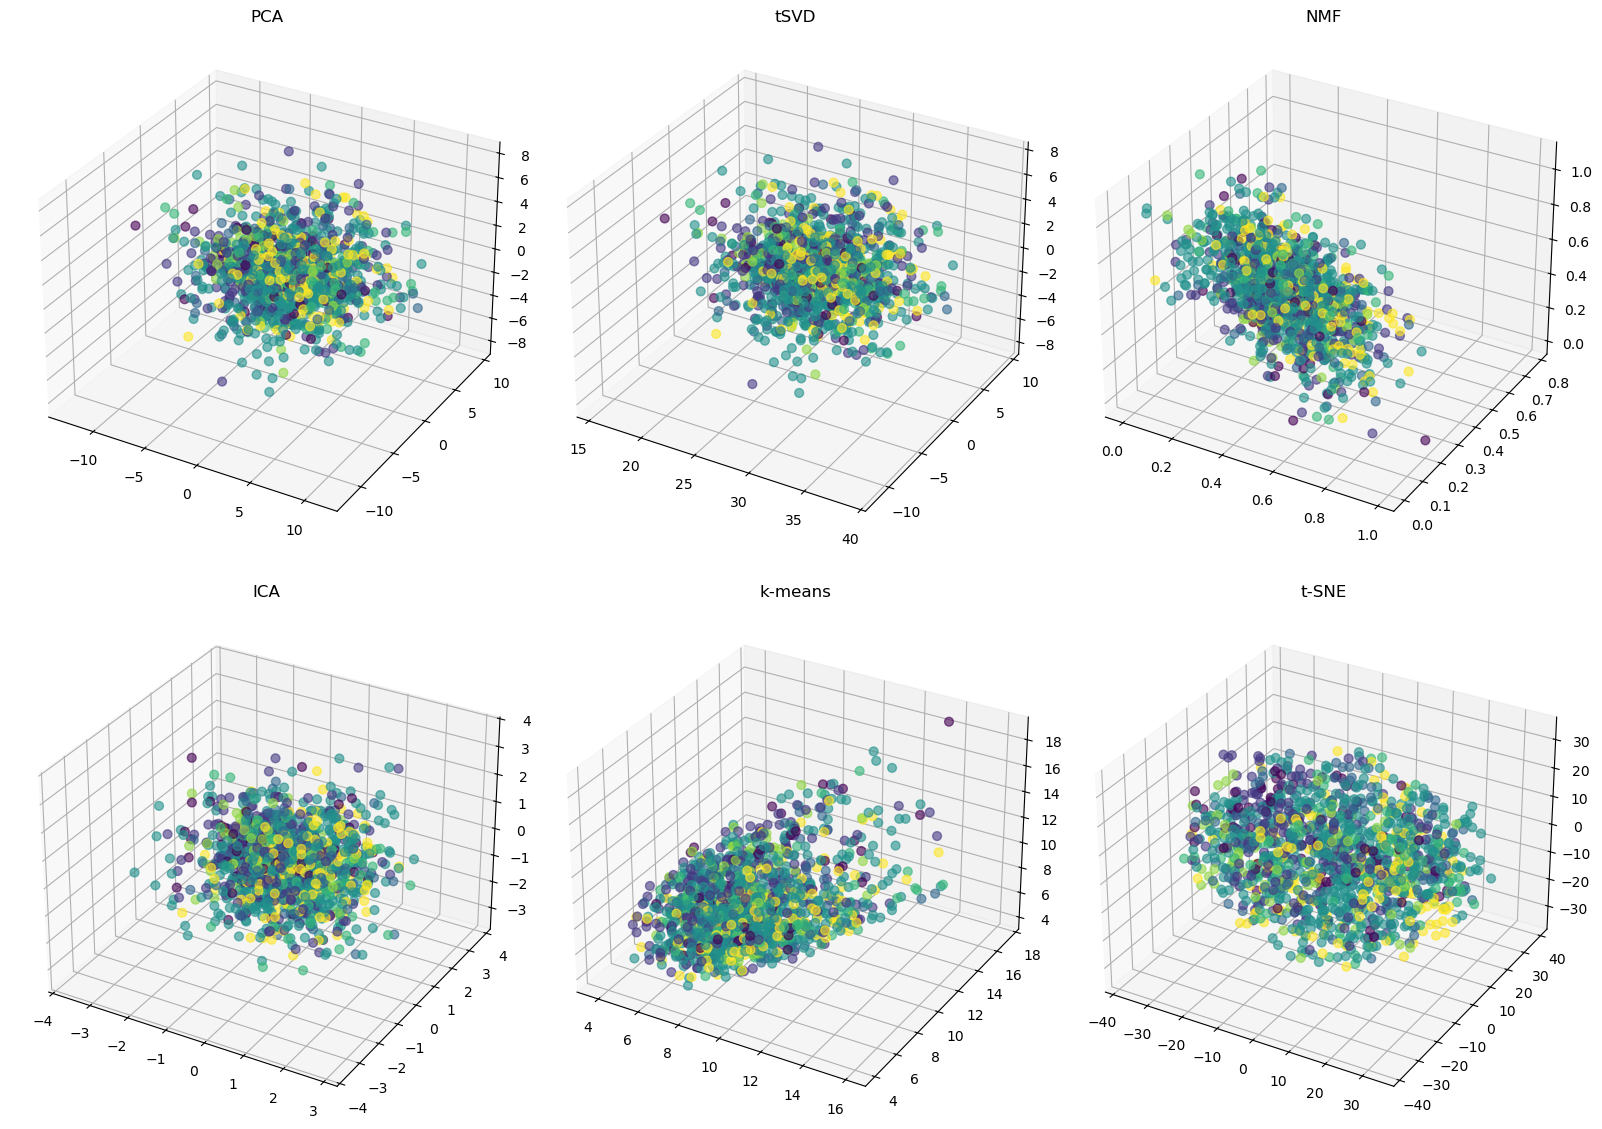

In [13]:
clfs = [decomposition.PCA(n_components=3), 
        decomposition.TruncatedSVD(n_components=3, algorithm='arpack'),
        decomposition.NMF(n_components=3), 
        decomposition.FastICA(n_components=3), 
        cluster.KMeans(n_clusters=3),
        manifold.TSNE(n_components=3)]

names = ['PCA', 'tSVD', 'NMF', 'ICA', 'k-means', 't-SNE']

trans = [clf.fit_transform(small_data.data) for clf in clfs]

from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D

lbl = preprocessing.LabelEncoder()
colors = lbl.fit_transform(small_data.target)

fig = plt.figure(figsize=(16, 12))
for tr, name, i in zip(trans, names, range(6)):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.scatter(tr[:, 0], tr[:, 1], tr[:, 2], c=colors, s=40, alpha=0.6)
    ax.set_title(name)

plt.tight_layout()